# Hierarchical Agglomerative Clustering

Hierarchical clustering (HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:

Agglomerative : This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy (most used). n --> 1

Divisive : This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy. 1 --> n

In agglomerative approach we don't specify number of clusters.

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

In [2]:
raw_data = pd.read_csv('raw_data/cc_general.csv')
raw_data = raw_data.drop('CUST_ID', axis=1)

raw_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [4]:
# Data investigation + cleaning (backward/forward observation to fullfill NaN values)

raw_data.fillna(method='ffill', inplace=True)

raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

In [5]:
# Data standardisation (σ=1, μ=0). Unit variance.
scaler = StandardScaler()
data_norm = scaler.fit_transform(raw_data.values)

# df from standardized data  
df_norm = pd.DataFrame(data_norm, index=raw_data.index, columns=raw_data.columns)
df_norm.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313,-0.675349,-0.476070,-0.511333,-0.960417,-0.528979,-0.305334,-0.525551,0.36068
1,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995,0.573963,0.110074,-0.591796,0.688654,0.818642,0.087140,0.234227,0.36068
2,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995,-0.675349,-0.476070,-0.109020,0.826076,-0.383805,-0.100110,-0.525551,0.36068
3,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995,-0.258913,-0.329534,-0.551565,0.826076,-0.598688,-0.100110,-0.525551,0.36068
4,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995,-0.675349,-0.476070,-0.551565,-0.905448,-0.364368,-0.261038,-0.525551,0.36068


In [6]:
# PCA with 2 components. 17 features of start dataset were reduces to 2 features

pca = PCA(n_components=2)

X_pca = pca.fit_transform(data_norm)

print('Original shape:', data_norm.shape)
print('PCA shape:', X_pca.shape)

X_pca`

Original shape: (8950, 17)
PCA shape: (8950, 2)


array([[-1.68059276, -1.07744398],
       [-1.14087505,  2.50596184],
       [ 0.97032494, -0.38212615],
       ...,
       [-0.92363988, -1.81049416],
       [-2.33495129, -0.65812718],
       [-0.55482115, -0.39779557]])

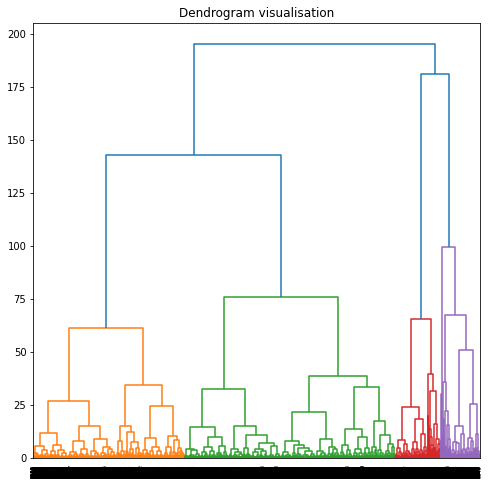

In [9]:
# Dendrogram with clusters (y=Euclidan distance, x=datapoints from pca)

plt.figure(figsize=(8,8))
plt.title('Dendrogram visualisation')
ddgr = shc.dendrogram(shc.linkage(X_pca, method='ward'))
plt.show()

# Linkage Types (1)  and Agglomerative Clustering parameters (2)

(1)

• WARD: minimization of clusters variance

• Average: Average distances of each observation between and within clusters

• Single: min. distances between clusters

• Complete: max. distances between clusters

(2)

Affinity is a metric used to compute the linkage/distances. Can be: euclidan distance, mahalanobis (for correlated data), cosine, square euclidean distance


In [108]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_pca)

print('Cluster labels:', cluster.labels_)

Cluster labels: [0 2 3 ... 0 0 0]


In [109]:
# Raw Data and custom DataFrame with clusters

cluster_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
print('Cluster_df shape:', cluster_df.shape)
raw_data['Cluster'] = cluster.labels_
cluster_df['Cluster'] = cluster.labels_

cluster_df.head()

Cluster_df shape: (8950, 2)


,PC1,PC2,Cluster
0,-1.680593,-1.077444,0
1,-1.140875,2.505962,2
2,0.970325,-0.382126,3
3,-0.879490,0.026129,0
4,-1.598362,-0.689879,0


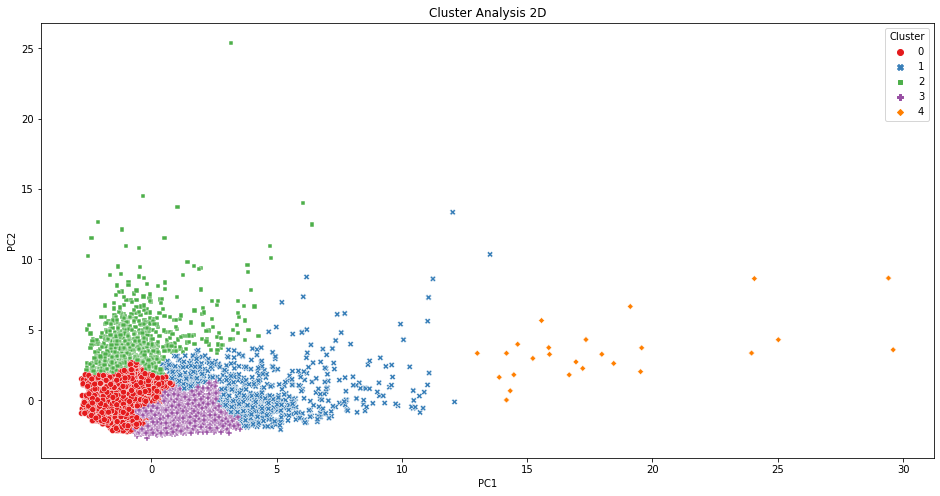

In [110]:
# Plotting data

plt.figure(figsize=(16, 8))
sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='Cluster', style='Cluster', palette='Set1')
plt.title('Cluster Analysis 2D')
plt.show()

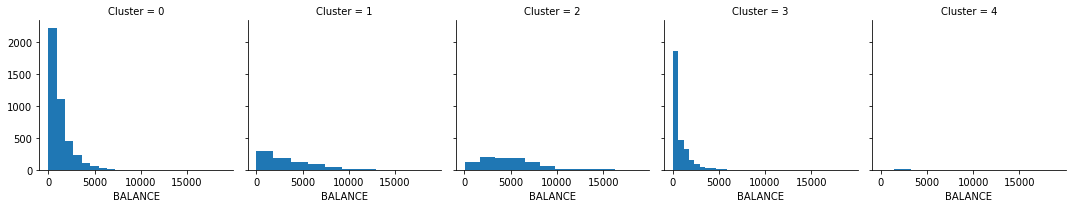

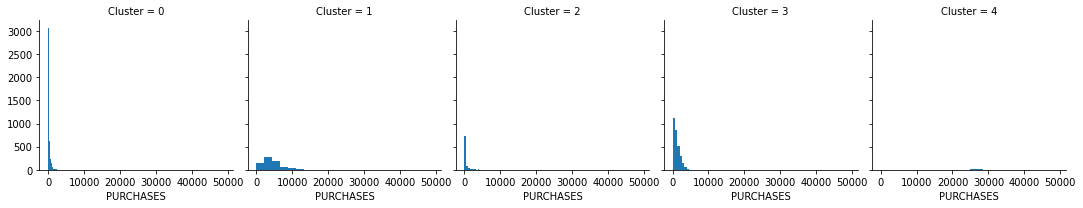

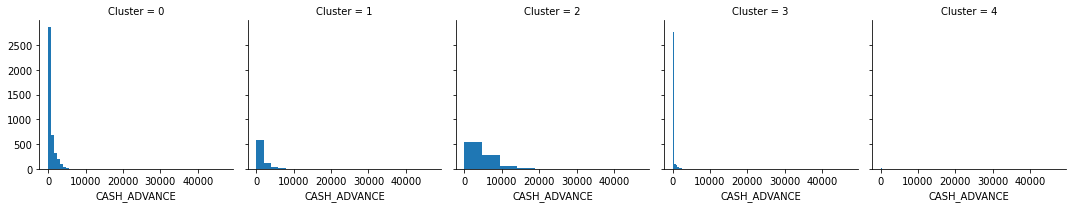

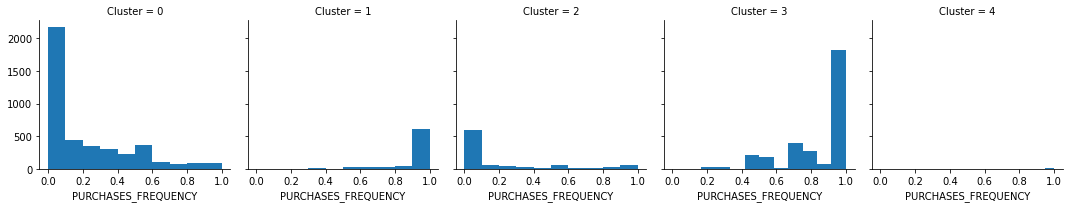

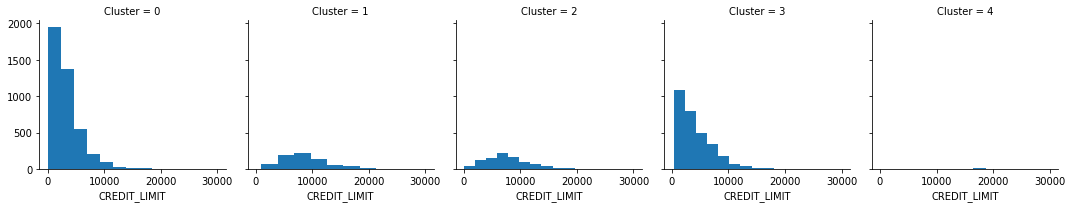

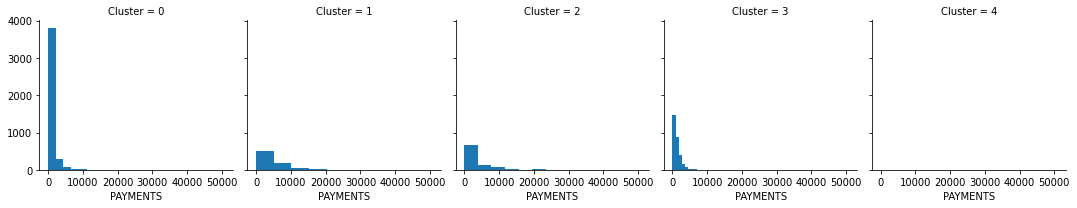

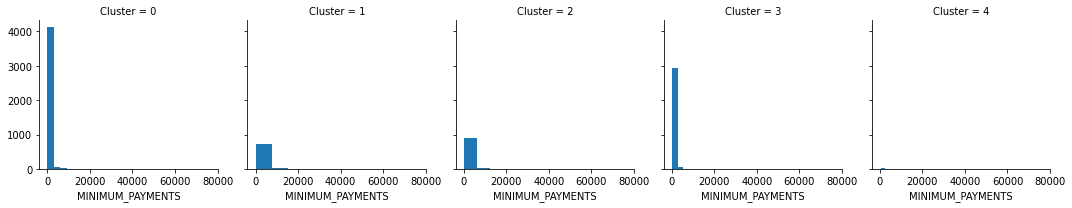

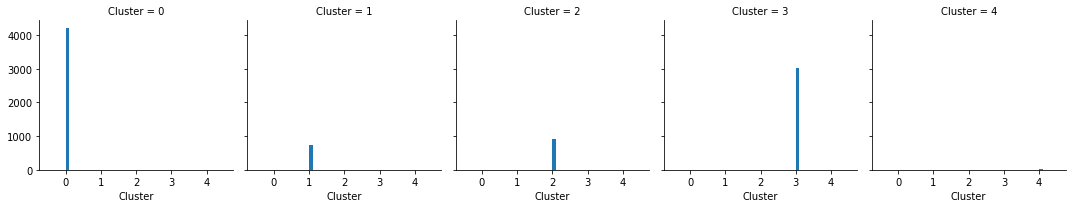

In [111]:
# Relevant columns for interpretaion
cols = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'Cluster']

for x in raw_data[cols]:
    grid = sns.FacetGrid(raw_data[cols], col='Cluster')
    grid.map(plt.hist, x)
    plt.show()

# Interpretation of Cluster Analysis

The majority of all customers are spread between cluster 0 and 3. The smallest amount of clients are in the 4th group (2D pic. above)

• Cluster 0: Relative high balance on the acc. Poor purchase activity. Very small amount of purchases. Low minimal payments (don't spend a lot at once)  

• Cluster 1: Mid balance on the credit card, but pretty frequent purchases. Low cash advance given by the user and mid credit limit. Can spend more than 0, 3 and 4 at one transaction 

• Cluster 2: Mid balance on the credit card. Low cash advance, with mid credit limit. Can spend more than 0, 3 and 4 at one transaction 

• Cluster 3: Frequent purchases with high amount. Very low minimum payments. Relative high balance on the acc. Very high cash advance.

• Cluster 4: Middle credit limit and very high purchase activity. 